In [1]:
!pip install -r requirements.txt

In [2]:
!pip install cybotrade-datasource
!pip install nest_asyncio

In [5]:
import cybotrade_datasource
from datetime import datetime, timezone
import pandas as pd

async def main():
    # fetch historical OHLCV data
    data = await cybotrade_datasource.query_paginated(
        api_key='rBXiCx58jJGLpVvy9ex7pHWt4usCfie3jCvnL9ypZdODodbp',
        topic='bybit-spot|candle?symbol=BTCUSDT&interval=1h',
        start_time=datetime(2024, 1, 1, tzinfo=timezone.utc),
        end_time=datetime(2024, 1, 10, tzinfo=timezone.utc)
    )
    
    # First, print the raw data to understand its structure
    print("Raw data sample:", data[:1])  # Print first element
    
    df = pd.DataFrame(data)
    
    # Print DataFrame columns to verify
    print("DataFrame columns:", df.columns.tolist())
    
    # Check for alternative time column names
    time_column = None
    for col in ['start_time', 'time', 'open_time', 'datetime']:
        if col in df.columns:
            time_column = col
            break
    
    if time_column:
        df['timestamp'] = pd.to_datetime(df[time_column], unit='ms')
    else:
        raise ValueError("No time column found in the data. Available columns: " + str(df.columns.tolist()))
    
    return df

# In Jupyter:
try:
    df = await main()
    print("\nProcessed Data:")
    print(df.head())
except Exception as e:
    print("Error:", str(e))

Raw data sample: [{'start_time': 1704067200000, 'close': 42475.28, 'high': 42552, 'low': 42260.01, 'open': 42284, 'volume': 175.962336}]
DataFrame columns: ['start_time', 'close', 'high', 'low', 'open', 'volume']

Processed Data:
      start_time     close      high       low      open      volume  \
0  1704067200000  42475.28  42552.00  42260.01  42284.00  175.962336   
1  1704070800000  42610.56  42777.73  42430.01  42475.28  255.900950   
2  1704074400000  42583.06  42635.99  42501.00  42610.56   98.789760   
3  1704078000000  42339.30  42591.99  42218.44  42583.06  208.943628   
4  1704081600000  42400.00  42400.00  42209.65  42339.30  149.562886   

            timestamp  
0 2024-01-01 00:00:00  
1 2024-01-01 01:00:00  
2 2024-01-01 02:00:00  
3 2024-01-01 03:00:00  
4 2024-01-01 04:00:00  


C:\Users\abdul\AppData\Local\Temp\ipykernel_26576\34281153.py:359: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  date_rng = pd.date_range(start='2023-01-01', periods=total_points, freq='H')


--- Running Bollinger + RSI Strategy ---


C:\Users\abdul\AppData\Local\Temp\ipykernel_26576\34281153.py:243: UserWarning: tight_layout not applied: number of rows in subplot specifications must be multiples of one another.
  plt.tight_layout()


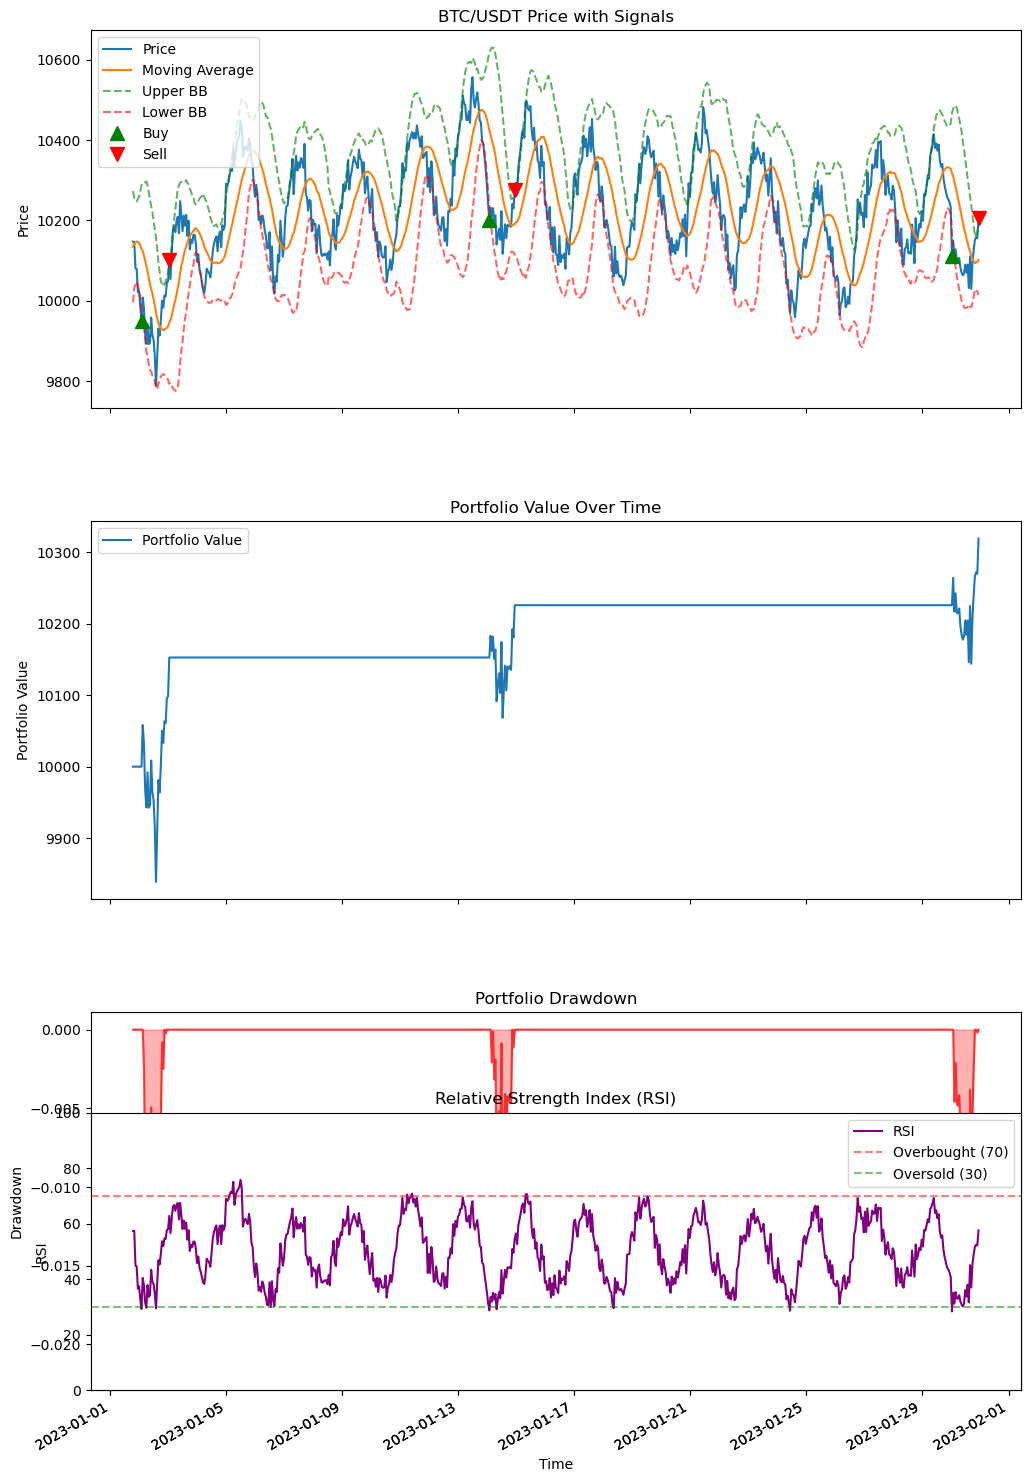


Bollinger + RSI Performance Metrics:
total_return: 3.19%
annual_return: 48.54%
sharpe_ratio: 3.3652
max_drawdown: -2.18%

--- Running SMA Crossover Strategy ---


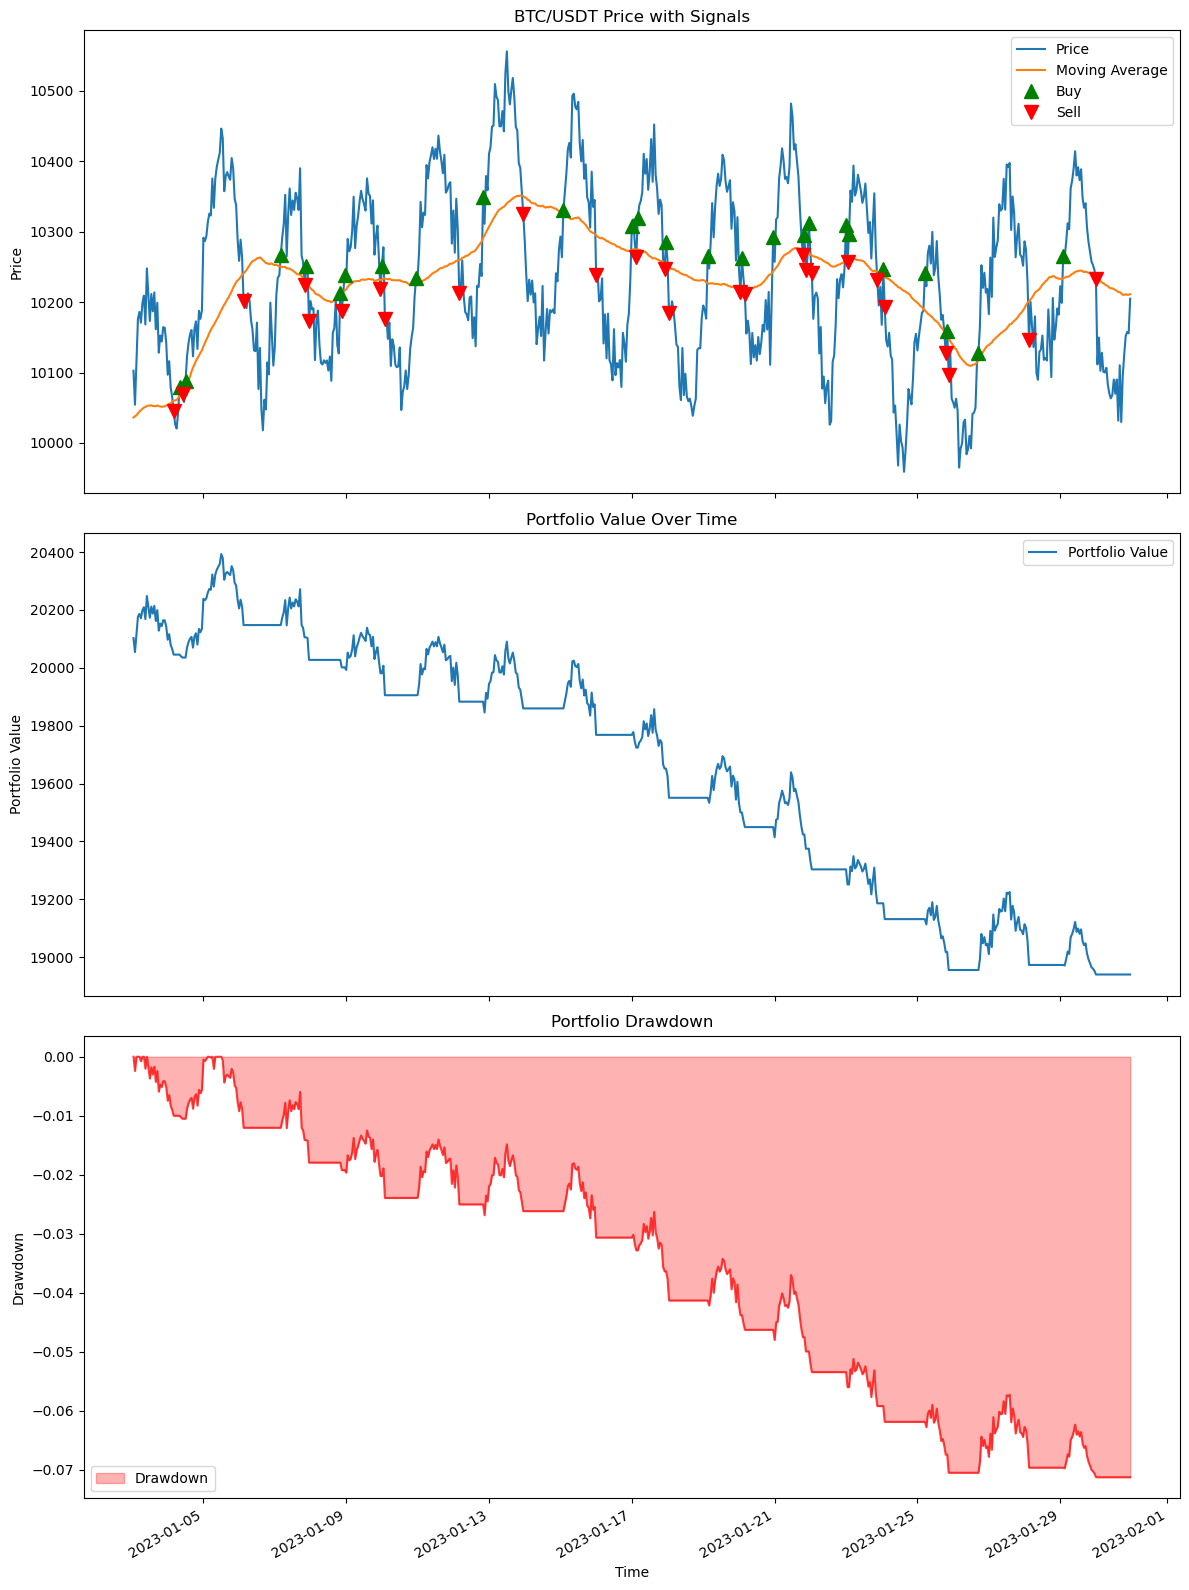


SMA Crossover Performance Metrics:
total_return: 89.40%
annual_return: 565240.23%
sharpe_ratio: -5.6423
max_drawdown: -7.13%


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# --- (Keep the Backtest class and strategy functions as they are) ---
class Backtest:
    def __init__(self, data, initial_capital=10000.0):
        # Ensure data has a proper index, especially if it's datetime
        self.data_initial_index = data.index # Keep track of the initial index if needed
        self.data = data.copy()
        self.initial_capital = initial_capital
        # Initialize with the original index
        self.positions = pd.DataFrame(index=data.index).fillna(0.0)
        self.portfolio = pd.DataFrame(index=data.index).fillna(0.0)

    def generate_signals(self, strategy_function, **kwargs):
        """Generate trading signals using the provided strategy function"""
        # Run the strategy, which might modify the DataFrame (e.g., dropna)
        self.data = strategy_function(self.data.copy(), **kwargs) # Pass a copy to strategy

        # --- FIX: Reindex portfolio and positions AFTER data is modified ---
        # Use the index of the (potentially shorter) self.data returned by the strategy
        self.positions = self.positions.reindex(self.data.index).fillna(0.0)
        self.portfolio = self.portfolio.reindex(self.data.index).fillna(0.0)
        # Initialize portfolio cash correctly based on potentially reduced data
        self.portfolio['cash'] = self.initial_capital
        # --- End FIX ---

        return self.data

    def calculate_positions(self):
        """Calculate positions based on signals"""
        # Ensure 'BTC' column exists before assigning
        if 'BTC' not in self.positions.columns:
             self.positions['BTC'] = 0.0

        # Check if 'signal' column exists in self.data
        if 'signal' not in self.data.columns:
             print("Warning: 'signal' column not found in data after generate_signals.")
             # Handle appropriately, maybe return or assign default 0
             self.positions['BTC'] = 0.0
        else:
            # Assign signals - alignment happens automatically due to reindexing
            self.positions['BTC'] = self.data['signal']

        # Fill any potential NaNs created during reindexing or assignment, if needed
        self.positions.fillna(0.0, inplace=True)
        return self.positions

    def calculate_portfolio_value(self):
        """Calculate portfolio value over time"""
        # Ensure columns exist
        if 'positions' not in self.portfolio.columns: self.portfolio['positions'] = 0.0
        if 'cash' not in self.portfolio.columns: self.portfolio['cash'] = self.initial_capital # Re-initialize cash correctly
        if 'total' not in self.portfolio.columns: self.portfolio['total'] = 0.0
        if 'returns' not in self.portfolio.columns: self.portfolio['returns'] = 0.0

        # --- Refined Calculation Logic ---
        # Calculate position changes
        position_diff = self.positions['BTC'].diff().fillna(0) # fillna(0) for the first row

        # Calculate cost/proceeds of trades
        trade_costs = position_diff * self.data['close']

        # Calculate holdings value
        self.portfolio['positions'] = self.positions['BTC'] * self.data['close']

        # Calculate cash: Start with initial capital and subtract cumulative costs
        # Ensure cash calculation starts AFTER the reindexing in generate_signals
        # Re-initialize cash before the loop/cumsum might be safer
        self.portfolio['cash'] = self.initial_capital - trade_costs.cumsum()

        # Calculate total portfolio value
        self.portfolio['total'] = self.portfolio['positions'] + self.portfolio['cash']

        # Calculate returns (handle potential division by zero or NaNs)
        self.portfolio['returns'] = self.portfolio['total'].pct_change().fillna(0.0)
        # --- End Refined Calculation Logic ---

        return self.portfolio

    def calculate_performance(self):
        """Calculate performance metrics"""
        # Ensure portfolio calculations have run and are not empty
        if self.portfolio.empty or 'total' not in self.portfolio.columns or self.portfolio['total'].isnull().all():
             print("Warning: Portfolio data is empty or invalid. Cannot calculate performance.")
             return {'total_return': 0, 'annual_return': 0, 'sharpe_ratio': 0, 'max_drawdown': 0}

        performance = {}
        # Use .iloc[-1] safely, check if portfolio has rows first
        if len(self.portfolio) > 0:
             performance['total_return'] = (self.portfolio['total'].iloc[-1] / self.initial_capital) - 1.0
        else:
             performance['total_return'] = 0.0

        # Calculate number of years based on actual data duration
        if len(self.data) > 1 and isinstance(self.data.index, pd.DatetimeIndex):
            years = (self.data.index[-1] - self.data.index[0]).days / 365.25
            if years > 0:
                 performance['annual_return'] = (1 + performance['total_return'])**(1/years) - 1
            else:
                 performance['annual_return'] = 0.0 # Avoid division by zero if duration is too short
        else:
            # Fallback if index is not datetime or too short
            # Assuming hourly data calculation might be inaccurate if data isn't exactly hourly
            # Or if the strategy drastically shortens the data length.
            print("Warning: Cannot accurately determine data duration for annualization.")
            performance['annual_return'] = 0.0 # Or use the previous estimate if applicable

        # Calculate Sharpe Ratio (handle zero standard deviation)
        returns_std = self.portfolio['returns'].std()
        if returns_std is not None and returns_std != 0:
            # Adjust annualization factor based on data frequency (e.g., 252 for daily, sqrt(365*24) for hourly)
            annualization_factor = np.sqrt(365 * 24) # Assuming hourly data, adjust if different
            performance['sharpe_ratio'] = annualization_factor * (self.portfolio['returns'].mean() / returns_std)
        else:
            performance['sharpe_ratio'] = 0.0 # Or np.nan

        # Calculate drawdown
        if len(self.portfolio) > 0:
             hwm = self.portfolio['total'].cummax()
             drawdown = (self.portfolio['total'] / hwm) - 1.0
             performance['max_drawdown'] = drawdown.min()
        else:
             performance['max_drawdown'] = 0.0

        return performance

    def run_backtest(self):
        """Run the full backtest"""
        # Signals are generated first (which now includes reindexing)
        # Then calculate positions based on the modified data/index
        self.calculate_positions()
        # Then calculate portfolio value using the correctly indexed positions/data
        self.calculate_portfolio_value()
        # Finally, calculate performance
        performance = self.calculate_performance()
        return performance

    def plot_results(self):
        """Plot backtest results"""
        # Ensure calculations have run and data exists
        if self.data.empty or self.portfolio.empty:
             print("Data or portfolio is empty, cannot plot.")
             return

        fig, axes = plt.subplots(3, 1, figsize=(12, 16), sharex=True)
        ax1, ax2, ax3 = axes # Unpack the axes

        # Use the DataFrame's index directly for plotting
        plot_index = self.data.index

        # Plot price and MA
        ax1.plot(plot_index, self.data['close'], label='Price')
        if 'MA' in self.data.columns:
            ax1.plot(plot_index, self.data['MA'], label='Moving Average')

        # Plot Bollinger Bands if they exist
        if 'BB_upper' in self.data.columns and 'BB_lower' in self.data.columns:
            ax1.plot(plot_index, self.data['BB_upper'], 'g--', label='Upper BB', alpha=0.6)
            ax1.plot(plot_index, self.data['BB_lower'], 'r--', label='Lower BB', alpha=0.6)

        # Highlight buy and sell signals using boolean masks
        # Calculate diff safely, handle potential NaN at the start
        # Use self.positions['BTC'] for plotting signals as it reflects the trades taken
        signal_diff = self.positions['BTC'].diff().fillna(0) # fillna to avoid issues with first row
        buy_signals_mask = (signal_diff > 0)
        sell_signals_mask = (signal_diff < 0)


        # Plot only if there are signals to avoid errors/warnings
        if buy_signals_mask.any():
            ax1.plot(plot_index[buy_signals_mask], self.data['close'][buy_signals_mask],
                     '^', markersize=10, color='g', label='Buy', linestyle='None') # Use linestyle='None'
        if sell_signals_mask.any():
            ax1.plot(plot_index[sell_signals_mask], self.data['close'][sell_signals_mask],
                     'v', markersize=10, color='r', label='Sell', linestyle='None') # Use linestyle='None'

        ax1.set_ylabel('Price')
        ax1.set_title('BTC/USDT Price with Signals')
        ax1.legend()

        # Plot portfolio value using the index
        ax2.plot(plot_index, self.portfolio['total'], label='Portfolio Value')
        ax2.set_ylabel('Portfolio Value')
        ax2.set_title('Portfolio Value Over Time')
        ax2.legend()

        # Plot drawdown
        hwm = self.portfolio['total'].cummax()
        drawdown = (self.portfolio['total'] / hwm) - 1.0
        # Use plot_index which aligns with drawdown Series index
        ax3.fill_between(plot_index, drawdown, 0, color='red', alpha=0.3, label='Drawdown')
        ax3.plot(plot_index, drawdown, color='red', alpha=0.7) # Optionally plot the line too
        ax3.set_ylabel('Drawdown')
        ax3.set_title('Portfolio Drawdown')
        ax3.legend() # Add legend for drawdown

        # Check if RSI exists and add subplot
        if 'RSI' in self.data.columns:
             # Make the current figure bigger to accommodate another subplot
            fig.set_figheight(20)  # Increase figure height

            # Add the fourth subplot using fig.add_subplot AFTER the initial axes creation
            ax4 = fig.add_subplot(4, 1, 4, sharex=ax1) # Share x-axis with ax1

            # Plot RSI
            ax4.plot(plot_index, self.data['RSI'], label='RSI', color='purple')

            # Add overbought/oversold lines if they exist in the data columns (more robust)
            # Or define them here based on standard practice or strategy parameters
            rsi_overbought = 70  # Example value
            rsi_oversold = 30   # Example value
            # Try to get from strategy if possible - needs passing params or storing them
            # If strategy stored params in data:
            # rsi_overbought = self.data.attrs.get('rsi_overbought', 70)
            # rsi_oversold = self.data.attrs.get('rsi_oversold', 30)

            ax4.axhline(y=rsi_overbought, color='r', linestyle='--', alpha=0.5, label=f'Overbought ({rsi_overbought})')
            ax4.axhline(y=rsi_oversold, color='g', linestyle='--', alpha=0.5, label=f'Oversold ({rsi_oversold})')

            ax4.set_ylabel('RSI')
            ax4.set_title('Relative Strength Index (RSI)')
            ax4.set_ylim(0, 100)  # RSI ranges from 0 to 100
            ax4.legend()
            # Assign ax4 to the last element for x-label setting below
            last_ax = ax4
        else:
            last_ax = ax3 # If no RSI plot, the last axis is ax3

        # Improve x-axis date formatting if the index is datetime
        if isinstance(plot_index, pd.DatetimeIndex):
            fig.autofmt_xdate() # Auto format date labels for better readability
        else:
            # Fallback for non-datetime index (like the original integer ticks)
            tick_indices = np.linspace(0, len(self.data)-1, 5, dtype=int)
            # Fallback to integer ticks if 'timestamp' column isn't present or not reliable
            last_ax.set_xticks(tick_indices)
            last_ax.set_xticklabels(tick_indices) # Show integer indices

        last_ax.set_xlabel("Time") # Add X-axis label to the *actual* bottom plot
        plt.tight_layout()
        # Adjust layout specifically if RSI plot was added
        if 'RSI' in self.data.columns:
             plt.subplots_adjust(hspace=0.3) # Add some vertical space between plots
        plt.show()

def bollinger_rsi_strategy(data, bb_window=20, bb_std=2, rsi_window=14, rsi_oversold=30, rsi_overbought=70):
    """
    Bollinger Bands + RSI strategy:
    - Buy when: Price is at/below lower Bollinger Band AND RSI is oversold
    - Sell when: Price is at/above upper Bollinger Band OR RSI is overbought

    Parameters:
    - bb_window: Window for Bollinger Bands calculation
    - bb_std: Number of standard deviations for Bollinger Bands
    - rsi_window: Window for RSI calculation
    - rsi_oversold: RSI level below which is considered oversold
    - rsi_overbought: RSI level above which is considered overbought
    """
    df = data.copy()

    # Calculate Bollinger Bands
    df['MA'] = df['close'].rolling(window=bb_window).mean()
    df['BB_std'] = df['close'].rolling(window=bb_window).std()
    df['BB_upper'] = df['MA'] + (df['BB_std'] * bb_std)
    df['BB_lower'] = df['MA'] - (df['BB_std'] * bb_std)

    # Calculate RSI using pandas_ta for robustness (optional but recommended)
    try:
        import pandas_ta as ta
        df.ta.rsi(length=rsi_window, append=True) # Appends 'RSI_14' column by default
        # Rename the column if needed
        df.rename(columns={f'RSI_{rsi_window}': 'RSI'}, inplace=True)
        # Handle cases where pandas_ta might not be installed
    except ImportError:
        print("Warning: pandas_ta not found. Using manual RSI calculation.")
        # Manual RSI Calculation (keep your original logic)
        delta = df['close'].diff()
        gain = delta.where(delta > 0, 0).fillna(0)
        loss = -delta.where(delta < 0, 0).fillna(0)

        # Use exponential moving average (EMA) for RSI calculation - more standard
        avg_gain = gain.ewm(com=rsi_window - 1, min_periods=rsi_window).mean()
        avg_loss = loss.ewm(com=rsi_window - 1, min_periods=rsi_window).mean()

        # Calculate RS and RSI
        rs = avg_gain / avg_loss
        df['RSI'] = 100 - (100 / (1 + rs))

    # Generate signals based on conditions
    buy_condition = (df['close'] <= df['BB_lower']) & (df['RSI'] <= rsi_oversold)
    sell_condition = (df['close'] >= df['BB_upper']) | (df['RSI'] >= rsi_overbought)

    # Initialize position flag and signal columns
    df['signal'] = 0.0 # Signal represents the *desired* position for the *next* period

    current_position = 0 # Track whether we are currently in a position (1) or not (0)
    # Use .loc for setting values to avoid SettingWithCopyWarning
    for i in df.index: # Iterate using the DataFrame index for robustness
        # Check for NaNs in indicators for the current row
        if pd.isna(df.loc[i, 'BB_lower']) or pd.isna(df.loc[i, 'BB_upper']) or pd.isna(df.loc[i, 'RSI']):
            df.loc[i, 'signal'] = current_position # Maintain position if indicators are NaN
            continue

        # Check entry condition: only enter if not already in a position
        if buy_condition.loc[i] and current_position == 0:
            current_position = 1
        # Check exit condition: only exit if currently in a position
        elif sell_condition.loc[i] and current_position == 1:
            current_position = 0

        # The signal for the current time step reflects the desired position state *after* checking conditions
        df.loc[i, 'signal'] = current_position

    # Drop rows with NaN indicators (essential for backtesting calculations)
    # Ensure 'MA' and 'RSI' are the primary indicators causing NaNs at the start
    df.dropna(subset=['MA', 'RSI', 'BB_upper', 'BB_lower'], inplace=True)

    # Optional: Store strategy parameters in DataFrame attributes for later use (e.g., plotting)
    df.attrs['rsi_overbought'] = rsi_overbought
    df.attrs['rsi_oversold'] = rsi_oversold


    return df


# You can also keep the original SMA crossover strategy as an option
def sma_crossover_strategy(data, window=20):
    """
    Simple Moving Average strategy
    Buy when price crosses above MA
    Sell when price crosses below MA (Hold cash when below)
    """
    df = data.copy() # Work on a copy
    df['MA'] = df['close'].rolling(window=window, min_periods=window).mean() # Ensure full window before calculating

    # Generate position flags (1 if Close > MA, 0 if Close <= MA)
    # Use np.where for clarity, ensures float type
    df['position_flag'] = np.where(df['close'] > df['MA'], 1.0, 0.0)

    # The signal is the desired position for the *current* period based on the flag.
    # In this simple case, the signal directly follows the position flag.
    df['signal'] = df['position_flag']

    # Drop NaNs introduced by the rolling window calculation BEFORE returning
    df.dropna(subset=['MA'], inplace=True) # Drop only rows where MA is NaN

    return df

# --- Example Usage with Real Data ---
# First, load historical data (replace this with your actual data loading)
# This example creates synthetic data that follows a more realistic price pattern
# --- CORRECTED load_sample_data ---
def load_sample_data(days=5, points_per_day=24):
    total_points = days * points_per_day
    # Use 'periods' to ensure the correct number of points
    date_rng = pd.date_range(start='2023-01-01', periods=total_points, freq='H')

    # Create a more realistic price series with trend, volatility, and some mean reversion
    base_price = 10000
    trend = np.linspace(0, 100, total_points)  # Small upward trend

    # Add some random walk component
    random_walk = np.random.normal(0, 1.5, total_points).cumsum() * 10 # Increased std dev

    # Add cyclical component
    cycles = 150 * np.sin(np.linspace(0, days * np.pi, total_points)) # Adjusted frequency

    # Add some noise/volatility
    noise = np.random.normal(0, 25, total_points) # Increased noise std dev

    # Combine components
    price_data = base_price + trend + random_walk + cycles + noise
    # Ensure price doesn't go below zero (or some reasonable floor)
    price_data = np.maximum(1, price_data)

    # Create DataFrame directly with index and data
    df = pd.DataFrame({'close': price_data}, index=date_rng)
    df.index.name = 'timestamp' # Assign a name to the index

    return df
# --- End CORRECTED load_sample_data ---


# Load data
df_original = load_sample_data(days=30, points_per_day=24) # Use longer data for better viz

# --- Run Bollinger+RSI Strategy ---
print("--- Running Bollinger + RSI Strategy ---")
backtest_brsi = Backtest(df_original.copy(), initial_capital=10000.0) # Pass a copy to backtest
backtest_brsi.generate_signals(bollinger_rsi_strategy,
                              bb_window=20,
                              bb_std=2,
                              rsi_window=14,
                              rsi_oversold=30,
                              rsi_overbought=70)
performance_brsi = backtest_brsi.run_backtest()
backtest_brsi.plot_results()

# Print performance metrics
print("\nBollinger + RSI Performance Metrics:")
if performance_brsi: # Check if performance dictionary is not empty/None
    for key, value in performance_brsi.items():
        # Format as percentage for relevant metrics
        if key in ['total_return', 'annual_return', 'max_drawdown']:
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.4f}") # Print Sharpe ratio with more precision
else:
    print("Could not calculate performance.")


# --- Optional: Compare with original SMA strategy ---
print("\n--- Running SMA Crossover Strategy ---")
backtest_sma = Backtest(df_original.copy(), initial_capital=10000.0) # Pass a copy
backtest_sma.generate_signals(sma_crossover_strategy, window=50) # Use a different window for SMA maybe
performance_sma = backtest_sma.run_backtest()
backtest_sma.plot_results() # Plot SMA results too

print("\nSMA Crossover Performance Metrics:")
if performance_sma:
    for key, value in performance_sma.items():
        if key in ['total_return', 'annual_return', 'max_drawdown']:
            print(f"{key}: {value:.2%}")
        else:
            print(f"{key}: {value:.4f}")
else:
    print("Could not calculate SMA performance.")